In [ ]:
import pandas as pd
import numpy as np

loading all the commodities

In [1]:
all_futures = all_instruments("Future")
x = r'\w{1,2}88'
commodity_futures = (all_futures[all_futures.order_book_id.str.contains(x)])
commodity_futures = commodity_futures.where((commodity_futures["de_listed_date"] == "0000-00-00")).dropna(how="all")
all_commodities = sorted(set(commodity_futures.where(all_futures["product"] == "Commodity").dropna(how="all").underlying_symbol))

In [ ]:
def calc_R_t(symbol):
  
#   get the dominant and spot futures
  dominant_future = get_dominant_future(symbol).loc[(slice("2010-01-01",None))]
  dates = dominant_future.index
  spot_futures = []
  for _d in dates:
    spot_future = get_future_contracts(symbol,_d)[0]
    spot_futures.append(spot_future)

  all_pairs =  np.concatenate((np.vstack(dominant_future.values),np.vstack(spot_futures)),axis=1)

#   geting the price
  all_price = []
  for i,_d in enumerate(dates[:]):
    p = ((get_price(all_pairs[i].tolist(),_d,_d,fields = "close")).values.squeeze()).tolist()
#     in case the two are the same
    if isinstance(p,float):
      p = [p]*2
    all_price.append(p)

  all_data = np.concatenate((all_pairs,np.vstack(dates)),axis=1)
#   calculating the date to maturity
  dominant_DTM = list(map(lambda x:instruments(x[0]).days_to_expire(x[-1]),all_data))
  spot_DTM = list(map(lambda x:instruments(x[1]).days_to_expire(x[-1]),all_data))

  DTM = pd.DataFrame(np.vstack((dominant_DTM,spot_DTM)),columns = dates,index=["dominants_DTM","spot_DTM"]).T
  all_price = pd.DataFrame(all_price,columns = ["dominant_price","spot_price"],index=dates)
  combined_data = pd.concat([DTM,all_price],axis=1)

  R_t = np.log(combined_data["spot_price"]/combined_data['dominant_price'])*(365/(combined_data["dominants_DTM"]-combined_data["spot_DTM"]))
  return R_t


 now start calculating! 

In [ ]:
results = {}
for s in all_commodities:
  results[s] = calc_R_t(s)
results = pd.concat(results.values(),keys = results.keys())

In [ ]:
# i have pickle the data,so i can reuse it 
# pd.concat(results.values(),keys = results.keys()).to_pickle("results.pkl")

analyse 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
# import seaborn as sns
# from pylab import *  
# mpl.rcParams['font.sans-serif'] = ['SimHei']  

In [3]:
results = pd.read_pickle("results.pkl").unstack()
continuous_contracts = [i+"88" for i in all_commodities]
codes2symbols = pd.Series(list(map(lambda x: instruments(x).symbol[:-4],continuous_contracts)),index=continuous_contracts)
dates_yearly = pd.date_range("2010-01-01","2018-01-01",freq="BAS")
mean_volume = pd.DataFrame()
for i,d in enumerate(dates_yearly[1:]):
  mean_volume[d] = pd.Series(list(map(lambda x: get_price(x,dates_yearly[i],d,fields="volume").mean(),continuous_contracts)),index=continuous_contracts)
mean_volume = pd.concat([codes2symbols,mean_volume],axis=1).set_index(0)

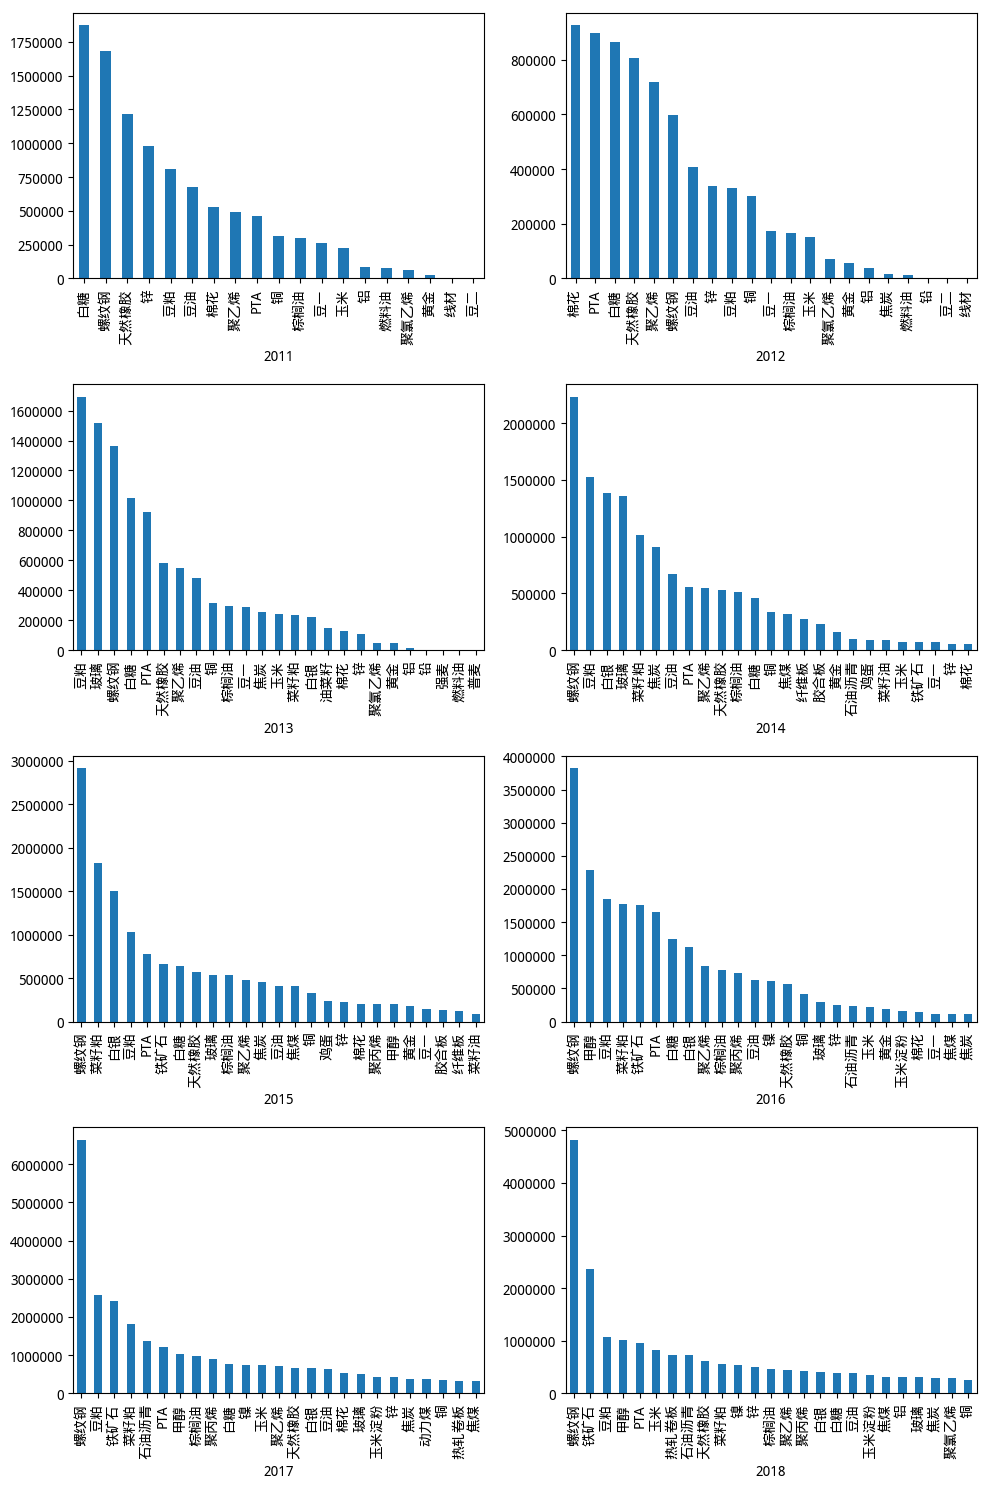

In [4]:
fig,ax = plt.subplots(4,2,figsize = (10,15))
for i,col in enumerate(mean_volume.columns):
  x = int(i/2)
  y = i%2
  _data_plot = mean_volume[col].dropna().sort_values(ascending=False)
  if len(_data_plot) >25:
    _data_plot = _data_plot.iloc[:25]
  _data_plot.plot.bar(ax=ax[x][y])
  ax[x][y].set_xlabel(col.date().year)
plt.tight_layout()


In [5]:
codes2symbols.index = codes2symbols.index.str.replace("88","")
combined_data = pd.concat([codes2symbols,results],axis=1).set_index(0)
liquity_contracts = mean_volume.apply(lambda x:pd.Series(x.sort_values(ascending=False).index[:20].tolist()))

In [6]:
liquity_contracts

,2011-01-03 00:00:00,2012-01-02 00:00:00,2013-01-01 00:00:00,2014-01-01 00:00:00,2015-01-01 00:00:00,2016-01-01 00:00:00,2017-01-02 00:00:00,2018-01-01 00:00:00
0,白糖,棉花,豆粕,螺纹钢,螺纹钢,螺纹钢,螺纹钢,螺纹钢
1,螺纹钢,PTA,玻璃,豆粕,菜籽粕,甲醇,豆粕,铁矿石
2,天然橡胶,白糖,螺纹钢,白银,白银,豆粕,铁矿石,豆粕
3,锌,天然橡胶,白糖,玻璃,豆粕,菜籽粕,菜籽粕,甲醇
4,豆粕,聚乙烯,PTA,菜籽粕,PTA,铁矿石,石油沥青,PTA
5,豆油,螺纹钢,天然橡胶,焦炭,铁矿石,PTA,PTA,玉米
6,棉花,豆油,聚乙烯,豆油,白糖,白糖,甲醇,热轧卷板
7,聚乙烯,锌,豆油,PTA,天然橡胶,白银,棕榈油,石油沥青
8,PTA,豆粕,铜,聚乙烯,玻璃,聚乙烯,聚丙烯,天然橡胶
9,铜,铜,棕榈油,天然橡胶,棕榈油,棕榈油,白糖,菜籽粕


In [8]:
combined_data = combined_data[combined_data.columns[combined_data.columns>datetime(2011,1,1)]]

In [10]:
def get_backwardation(series):
  _date = series.name
  _liquity_contracts = liquity_contracts[liquity_contracts.columns.where(liquity_contracts.columns<_date).dropna()].iloc[:,-1].values.squeeze().tolist()
  return pd.Series(series.loc[_liquity_contracts].where(series>0).dropna().sort_values(ascending=False).index[:5].tolist())
  

In [9]:
def get_Contango(series):
  _date = series.name
  _liquity_contracts = liquity_contracts[liquity_contracts.columns.where(liquity_contracts.columns<_date).dropna()].iloc[:,-1].values.squeeze().tolist()
  return pd.Series(series.loc[_liquity_contracts].where(series<0).dropna().sort_values(ascending=True).index[:5].tolist())
  

In [11]:
def calc_rtns(series):
  _date = series.name
  _contracts = series.dropna().values.tolist()
  if len(_contracts)>0:
    _dominants_contracts = list(map(lambda x:get_dominant_future(x,_date).values[0],_contracts))
    nxt_date = get_next_trading_date(_date)
    _price = get_price(_dominants_contracts,_date,nxt_date,fields="close")
#     print(_price)
    return (_price.iloc[-1]/_price.iloc[0]-1).mean()
  else:
    return np.nan

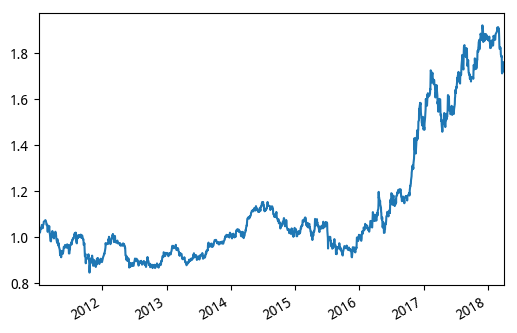

In [12]:
selected_contracts = combined_data.apply(lambda x:get_backwardation(x))
symbols2Codes = codes2symbols.reset_index().set_index(0).to_dict()['index']
selected_contracts = selected_contracts.replace(symbols2Codes)
all_rtns = selected_contracts.iloc[:,:].apply(lambda x:calc_rtns(x))
all_rtns.add(1).cumprod().plot()

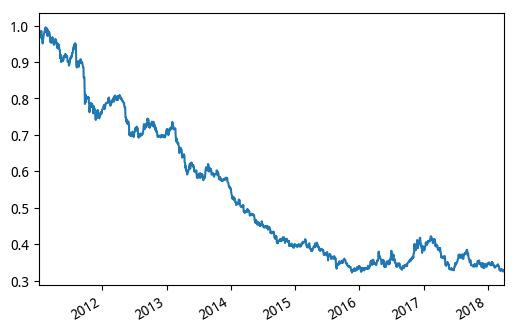

In [13]:
selected_contracts_contango = combined_data.apply(lambda x:get_Contango(x))
symbols2Codes = codes2symbols.reset_index().set_index(0).to_dict()['index']
selected_contracts_contango = selected_contracts_contango.replace(symbols2Codes)
all_rtns_contango = selected_contracts_contango.iloc[:,:].apply(lambda x:calc_rtns(x))
all_rtns_contango.add(1).cumprod().plot()